In [1]:
import h5py
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

from neuropacks import PVC11
from utils import plot_coupling_grid

%matplotlib inline

In [2]:
data_path = os.path.join(os.environ['HOME'],
                         'data/pvc11/data/spikes_gratings/data_monkey1_gratings.mat')

In [3]:
pvc11 = PVC11(data_path=data_path)

In [4]:
monkeys = ['monkey1', 'monkey2', 'monkey3']
n_monkeys = len(monkeys)

In [5]:
results_paths = [os.path.join(os.environ['HOME'],
                              'fits/uoineuro/coupling/pvc11/' + monkey + '.h5')
                 for monkey in monkeys]

In [6]:
fits = [h5py.File(results_paths[idx], 'r')
        for idx in range(n_monkeys)]

# Metric Comparison: Poisson

In [8]:
baselines = [fits[idx]['glmnet_poisson'] for idx in range(n_monkeys)]
algorithms = [[fits[idx]['uoi_poisson_log'], fits[idx]['uoi_poisson_AIC'], fits[idx]['uoi_poisson_BIC']]
              for idx in range(n_monkeys)]

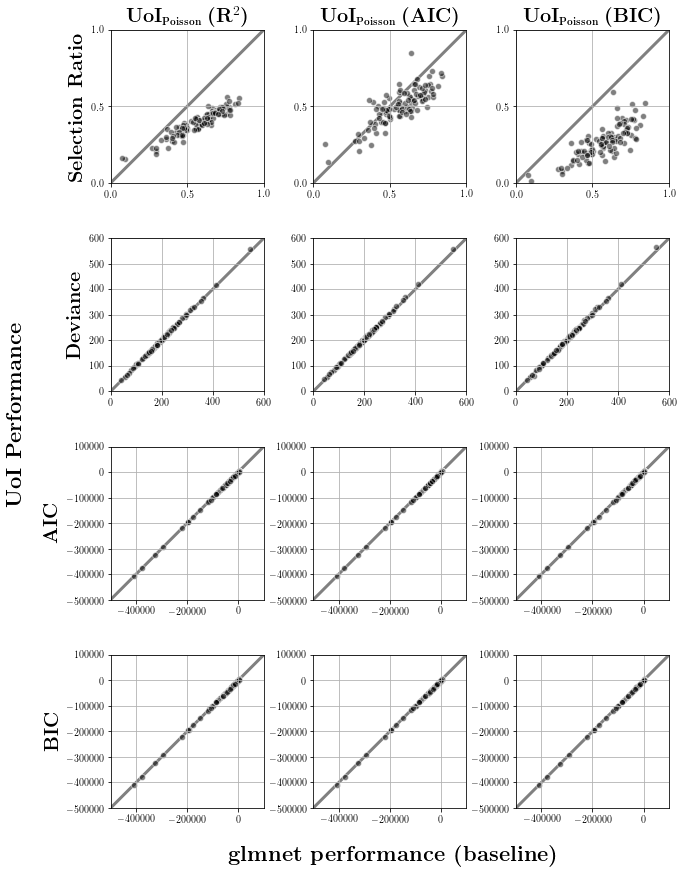

In [11]:
fig, axes = plot_coupling_grid(baseline_group=baselines[0],
                               fits_groups=algorithms[0],
                               metrics=['selection_ratio', 'deviances_test', 'AICs', 'BICs'])

# additional customizations #

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([0, 600])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')

# third row: AIC
for idx in range(3):
    ax = axes[2, idx]
    ax.set_xlim([-500000, 100000])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')
    
# third row: BIC
for idx in range(3):
    ax = axes[3, idx]
    ax.set_xlim([-500000, 100000])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')

for ax in axes.ravel():
    ax.tick_params(labelsize=10)

axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Deviance}', fontsize=20)
axes[2, 0].set_ylabel(r'\textbf{AIC}', fontsize=20)
axes[3, 0].set_ylabel(r'\textbf{BIC}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{glmnet performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()
plt.savefig('pvc11_coupling_metric_summary.pdf', bbox_inches='tight')

# Connectivity Plot

In [12]:
glmnet_coupling_coefs = np.zeros((pvc11.n_neurons, pvc11.n_neurons))
uoi_coupling_coefs = np.zeros((pvc11.n_neurons, pvc11.n_neurons))

In [13]:
glmnet_median_coefs = np.median(baselines[0]['coupling_coefs'], axis=0)
uoi_median_coefs = np.median(algorithms[0][2]['coupling_coefs'], axis=0)

In [14]:
for neuron in range(pvc11.n_neurons):
    glmnet_coupling_coefs[neuron] = np.insert(glmnet_median_coefs[neuron], neuron, 0)
    uoi_coupling_coefs[neuron] = np.insert(uoi_median_coefs[neuron], neuron, 0) 

In [15]:
G_glmnet = nx.Graph()
G_uoi = nx.Graph()

In [16]:
# add nodes
for electrode in range(pvc11.n_neurons):
    G_glmnet.add_node(electrode)
    G_uoi.add_node(electrode)

In [17]:
weights_glmnet = {}
weights_uoi = {}

for neuron_pair in itertools.combinations(np.arange(pvc11.n_neurons), 2):
    n1, n2 = neuron_pair
    weight = 0.5 * (glmnet_coupling_coefs[n1, n2] + glmnet_coupling_coefs[n2, n1])
    if weight != 0:
        weights_glmnet[neuron_pair] = np.sign(weight) * np.sqrt(np.abs(weight))
        G_glmnet.add_weighted_edges_from([(n1, n2, weight)])

    weight = 0.5 * (uoi_coupling_coefs[n1, n2] + uoi_coupling_coefs[n2, n1])
    if weight != 0:
        weights_uoi[neuron_pair] = np.sign(weight) * np.sqrt(np.abs(weight))
        G_uoi.add_weighted_edges_from([(n1, n2, weight)])

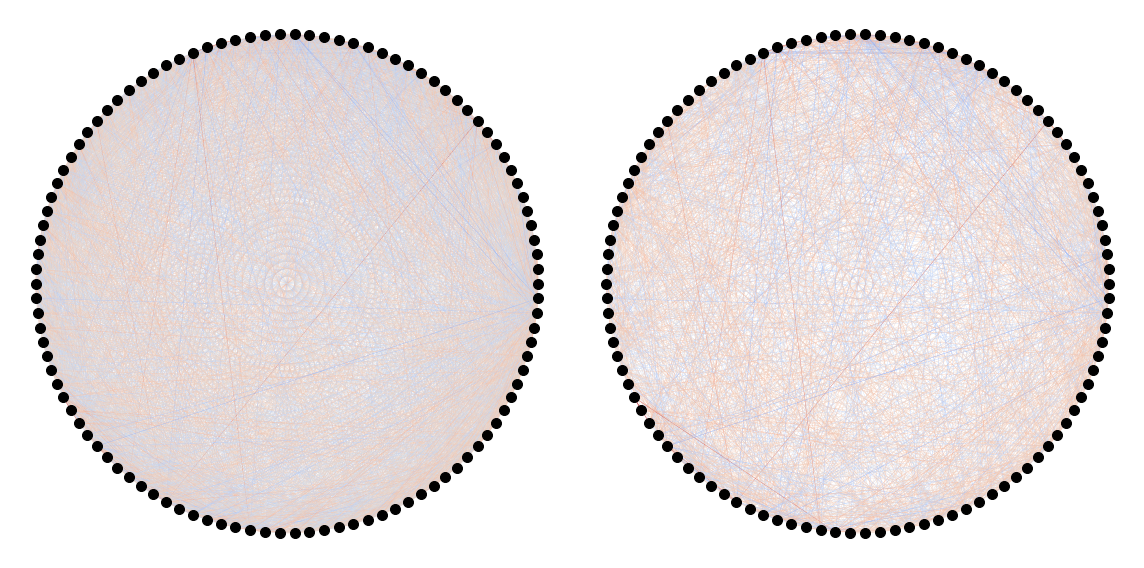

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

nx.draw_circular(
    G_glmnet,
    node_size=100,
    node_color='k',
    width=0.25 + np.abs(list(weights_glmnet.values()))**2,
    edge_color=list(weights_glmnet.values()),
    edge_cmap=plt.get_cmap('coolwarm'),
    edge_vmin=-0.4,
    edge_vmax=0.4,
    ax=axes[0])

nx.draw_circular(
    G_uoi,
    node_size=100,
    node_color='k',
    width=0.25 + np.abs(list(weights_uoi.values()))**2,
    edge_color=list(weights_uoi.values()),
    edge_cmap=plt.get_cmap('coolwarm'),
    edge_vmin=-0.4,
    edge_vmax=0.4,
    ax=axes[1])

plt.tight_layout()
plt.savefig('pvc11_connectivity_graph.pdf', bbox_inches='tight')

# Metric Comparison: Lasso

In [7]:
baselines = [fits[idx]['lasso'] for idx in range(n_monkeys)]
algorithms = [[fits[idx]['uoi_lasso_r2'], fits[idx]['uoi_lasso_aic'], fits[idx]['uoi_lasso_bic']]
              for idx in range(n_monkeys)]

In [13]:
Y = baselines[0]['Y'][:]

array([[1.        , 2.23606798, 0.        , ..., 1.73205081, 0.        ,
        1.        ],
       [0.        , 2.23606798, 0.        , ..., 1.41421356, 0.        ,
        0.        ],
       [0.        , 2.82842712, 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.41421356, 3.60555128, 0.        , ..., 1.73205081, 0.        ,
        0.        ],
       [1.        , 2.23606798, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [1.73205081, 2.64575131, 0.        , ..., 1.41421356, 0.        ,
        0.        ]])

In [21]:
algorithms[0][1]['Y'][:]

array([[ 1.,  5.,  0., ...,  3.,  0.,  1.],
       [ 0.,  5.,  0., ...,  2.,  0.,  0.],
       [ 0.,  8.,  0., ...,  1.,  1.,  1.],
       ...,
       [ 2., 13.,  0., ...,  3.,  0.,  0.],
       [ 1.,  5.,  0., ...,  1.,  0.,  1.],
       [ 3.,  7.,  0., ...,  2.,  0.,  0.]])

In [20]:
np.all(baselines[0]['training_folds/fold_0'][:] == algorithms[0][1]['training_folds/fold_0'][:])

True

In [19]:
algorithms[0][1]['training_folds/fold_0'][:]

array([   0,    1,    4, ..., 2396, 2397, 2398])

In [9]:
algorithms[0][1]

[<HDF5 group "/uoi_lasso_r2" (8 members)>,
 <HDF5 group "/uoi_lasso_aic" (8 members)>,
 <HDF5 group "/uoi_lasso_bic" (8 members)>]

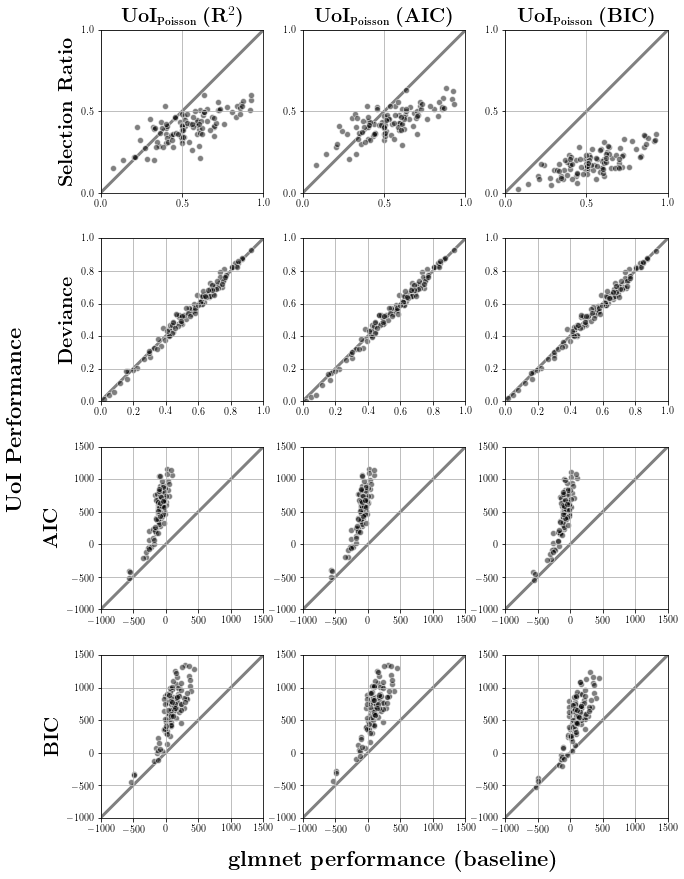

In [8]:
fig, axes = plot_coupling_grid(baseline_group=baselines[0],
                               fits_groups=algorithms[0],
                               metrics=['selection_ratio', 'r2', 'AIC', 'BIC'])

# additional customizations #

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')
    
    
# third row: AIC
for idx in range(3):
    ax = axes[2, idx]
    ax.set_xlim([-1000, 1500])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')
    
# third row: BIC
for idx in range(3):
    ax = axes[3, idx]
    ax.set_xlim([-1000, 1500])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')

for ax in axes.ravel():
    ax.tick_params(labelsize=10)

axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Deviance}', fontsize=20)
axes[2, 0].set_ylabel(r'\textbf{AIC}', fontsize=20)
axes[3, 0].set_ylabel(r'\textbf{BIC}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{glmnet performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()